In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,auc,roc_auc_score
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import scipy

In [2]:
#数据加载、PCA降维、数据均衡化
train_features=np.load('train_features.npy')
train_labels=np.load('train_labels.npy')
test_features=np.load('test_features.npy')

pca = PCA(n_components=63)
pca.fit(train_features)
train_feature= pca.transform(train_features)
test_feature= pca.transform(test_features)

smote = SMOTE(random_state=2002)
X_resampled, y_resampled = smote.fit_resample(train_feature, train_labels)

In [15]:
#最优模型参数选择
import numpy as np
from sklearn.model_selection import GridSearchCV
parameters={'kernel':['linear','rbf','sigmoid','poly'],'C':np.linspace(0.1,20,50),'gamma':np.linspace(0.1,20,20)}
svc = svm.SVC()
train_data,test_data,train_label,test_label =train_test_split(train_feature,train_labels, random_state=2022, train_size=0.8,test_size=0.2) #sklearn.model_selection.
model = GridSearchCV(svc,parameters,cv=5,scoring='accuracy')
model.fit(train_data,train_label)
model.score(test_data,test_label)

0.9475262368815592

In [16]:
#输出网格搜索后模型最佳参数
model.best_params_

{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}

In [22]:
#训练200个SVM分类器，并对每次训练加正太分布噪声，对最终测试集上数据采用投票方式确定实际分类
model_all=[]
roc_auc_score0=[]
for k in range(200):
    Var0 = X_resampled.var(axis = 0)
    var=np.zeros((7500,63))
    for i in range(63):
        a=np.random.normal(0,0.1*pow(Var0,0.5)[i],[7500,1])
        for j in range(7500):
            var[j][i]=a[j]
    X_resampled0=X_resampled+var
    train_data,test_data,train_label,test_label =train_test_split(X_resampled0,y_resampled,stratify=y_resampled, random_state=k, train_size=0.80,test_size=0.20) #sklearn.model_selection.
    classifier = svm.SVC(C=0.1, kernel='linear',gamma=0.1,probability=True)
    classifier.fit(train_data,train_label.ravel()) #ravel函数在降维时默认是行序优先
    roc_auc_score0.append(roc_auc_score(test_label,classifier.predict_proba(test_data),multi_class='ovr')) #模型评估
    model_all.append(classifier)
    print("训练集：",classifier.score(train_data,train_label))
    print("验证集：",classifier.score(test_data,test_label))
test_result=np.zeros((2857,200))
for k in range(200):
    test_result0=model_all[k].predict(test_feature)
    for i in range(2857):
        test_result[i][k]=test_result0[i]
test_results=scipy.stats.mode(test_result,1)
print(test_results)
np.savetxt('outputSVM.csv', test_results[0], delimiter=', ')

训练集： 0.9958333333333333
验证集： 0.9526666666666667
训练集： 0.996
验证集： 0.9546666666666667
训练集： 0.996
验证集： 0.958
训练集： 0.9968333333333333
验证集： 0.9533333333333334
训练集： 0.9963333333333333
验证集： 0.9533333333333334
训练集： 0.997
验证集： 0.9546666666666667
训练集： 0.9968333333333333
验证集： 0.9493333333333334
训练集： 0.9958333333333333
验证集： 0.9533333333333334
训练集： 0.9953333333333333
验证集： 0.9586666666666667
训练集： 0.9953333333333333
验证集： 0.9546666666666667
训练集： 0.9948333333333333
验证集： 0.9526666666666667
训练集： 0.996
验证集： 0.9486666666666667
训练集： 0.9951666666666666
验证集： 0.954
训练集： 0.995
验证集： 0.9573333333333334
训练集： 0.9963333333333333
验证集： 0.9533333333333334
训练集： 0.9968333333333333
验证集： 0.956
训练集： 0.9953333333333333
验证集： 0.9546666666666667
训练集： 0.9958333333333333
验证集： 0.96
训练集： 0.9956666666666667
验证集： 0.9546666666666667
训练集： 0.9951666666666666
验证集： 0.962
训练集： 0.9966666666666667
验证集： 0.9566666666666667
训练集： 0.9956666666666667
验证集： 0.9533333333333334
训练集： 0.996
验证集： 0.9606666666666667
训练集： 0.9961666666666666
验证集： 0.966666666

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_59316\1051042059.py:24: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  test_results=scipy.stats.mode(test_result,1)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_59316\1701475012.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_axis_data, roc_auc_score0, 'ro-', color='#4169E1', alpha=0.8, linewidth=1 )
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


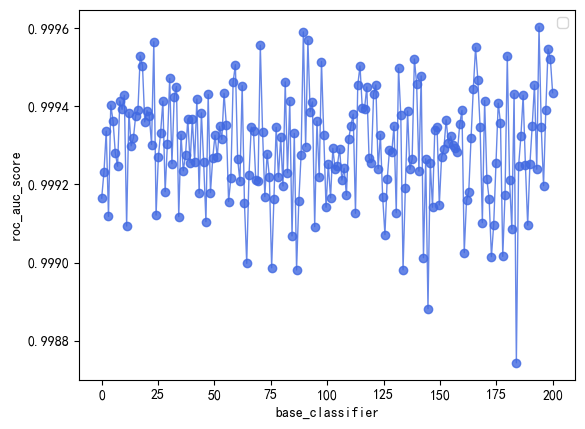

In [27]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
x_axis_data = np.linspace(0, 200,200 )
plt.plot(x_axis_data, roc_auc_score0, 'ro-', color='#4169E1', alpha=0.8, linewidth=1 )
plt.legend(loc="upper right")
plt.xlabel('base_classifier')
plt.ylabel('roc_auc_score')
plt.show()
